# Personalized Restaurant Recommendation (Google Restaurants)

**Task.** Given a user `u` and an unseen restaurant `i`, predict a personalized recommendation score $\hat{r}_{u,i}$ (used for ranking). We evaluate bour rating prediction with **RMSE** and **MAE**.

**Dataset.** Google Restaurants — dataset of restaurants from Google Local (Google Maps). Data includes images and reviews posted by users. We use the filtered subset `filter_all_t.json` and ensure all train/validation/test statistics are computed from TRAIN only to avoid leakage.

## 1. Data Preprocessing and Analysis

In [52]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error



with open("filter_all_t.json", "r") as f:
    data = json.load(f)

train_df = pd.DataFrame(data["train"])
val_df   = pd.DataFrame(data.get("val", []))
test_df  = pd.DataFrame(data.get("test", []))

# Remove pics coloumn to save memory
train_df = train_df.drop(columns=["pics"], errors="ignore")
val_df   = val_df.drop(columns=["pics"], errors="ignore")
test_df  = test_df.drop(columns=["pics"], errors="ignore")

In [28]:
train_df.head()

,business_id,user_id,rating,review_text,history_reviews
0,60567465d335d0abfb415b26,101074926318992653684,4,The tang of the tomato sauce is outstanding. A...,[[101074926318992653684_6056272797d555cc6fb0d1...
1,6050fa9f5b4ccec8d5cae994,117065749986299237881,5,Chicken and waffles were really good!,[[117065749986299237881_605206f8d8c08f462b93e8...
2,604be10877e81aaed3cc9a1e,106700937793048450809,4,The appetizer of colossal shrimp was very good...,[[106700937793048450809_6044300b27f39b7b5d1dbf...
3,60411e017cd8bf130362365a,101643045857250355161,5,The fish tacos here omg! The salad was great ...,[[101643045857250355161_604fbdd099686c10168c91...
4,604139dd7cd8bf1303624208,109802745326785766951,4,"Ribs are great, as are the mac and cheese, fri...",[[109802745326785766951_60524fa9f09a4ffff042f9...


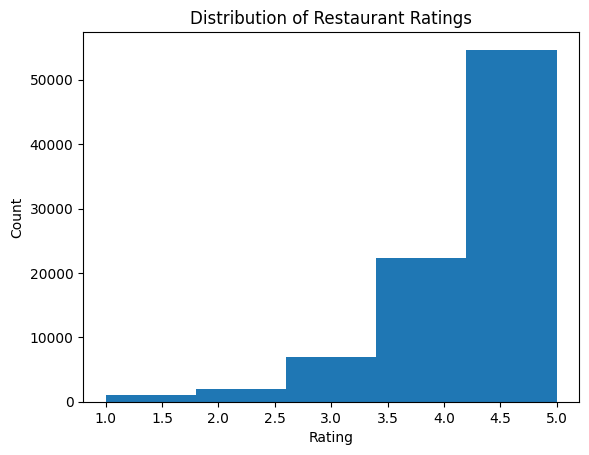

In [29]:
import matplotlib.pyplot as plt

plt.hist(train_df["rating"], bins=5)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Restaurant Ratings")
plt.show()

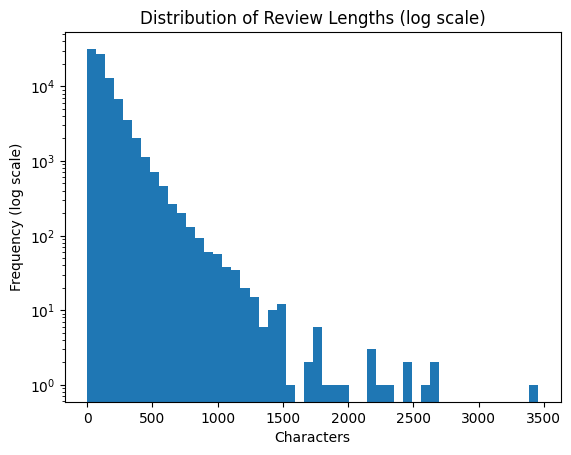

In [30]:
train_df["review_length"] = train_df["review_text"].apply(lambda x: len(x) if isinstance(x, str) else 0)

plt.hist(train_df["review_length"], bins=50, log=True)
plt.title("Distribution of Review Lengths (log scale)")
plt.xlabel("Characters")
plt.ylabel("Frequency (log scale)")
plt.show()


In [53]:
#Add Basic Numerical Features
user_avg = train_df.groupby("user_id")["rating"].mean()
item_avg = train_df.groupby("business_id")["rating"].mean()
user_count = train_df.groupby("user_id").size()
item_count = train_df.groupby("business_id").size()

def add_features(df):
    df["user_avg"]   = df["user_id"].map(user_avg)
    df["item_avg"]   = df["business_id"].map(item_avg)
    df["user_count"] = df["user_id"].map(user_count)
    df["item_count"] = df["business_id"].map(item_count)
    df["review_len"] = df["review_text"].str.len()

    df[["user_avg", "item_avg", "user_count", "item_count"]] = \
    df[["user_avg", "item_avg", "user_count", "item_count"]].fillna(0)

    return df

train_df = add_features(train_df)
val_df   = add_features(val_df)
test_df  = add_features(test_df)

## 2. Baseline Model (TF-IDF)

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000, stop_words="english")

X_train_text = tfidf.fit_transform(train_df["review_text"])
X_val_text   = tfidf.transform(val_df["review_text"])
X_test_text  = tfidf.transform(test_df["review_text"])

In [85]:
from scipy.sparse import hstack

numeric_cols = ["user_avg", "item_avg", "user_count", "item_count", "review_len"]

X_train_num = train_df[numeric_cols].values
X_val_num   = val_df[numeric_cols].values
X_test_num  = test_df[numeric_cols].values

X_train = hstack([X_train_text, X_train_num])
X_val   = hstack([X_val_text,   X_val_num])
X_test  = hstack([X_test_text,  X_test_num])

y_train = train_df["rating"].values
y_val   = val_df["rating"].values
y_test  = test_df["rating"].values

In [86]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_val = lr.predict(X_val)
pred_test = lr.predict(X_test)

# Compute RMSE and MAE
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_val = mean_absolute_error(y_val, pred_val)
mae_test = mean_absolute_error(y_test, pred_test)

print("LR Val RMSE:", rmse_val, "MAE:", mae_val)
print("LR Test RMSE:", rmse_test, "MAE:", mae_test)

LR Val RMSE: 3.4299988123982015 MAE: 3.2318278162844822
LR Test RMSE: 3.4328811115743565 MAE: 3.2400858208411947


## 3. SVD Model

In [60]:
from sklearn.decomposition import TruncatedSVD

# 1. Pivot train data to create user-item matrix
user_item_matrix = train_df.pivot(index='user_id', columns='business_id', values='rating').fillna(0)

# Keep track of users/items order
train_users = user_item_matrix.index
train_items = user_item_matrix.columns

R_train = user_item_matrix.values

# 2. Fit TruncatedSVD on train matrix
n_factors = 20
svd = TruncatedSVD(n_components=n_factors, random_state=42)
U = svd.fit_transform(R_train)      # user latent vectors
V = svd.components_.T               # item latent vectors

# 3. Compute predicted ratings for TRAIN users/items
R_hat_train = np.dot(U, V.T)
pred_train_df = pd.DataFrame(R_hat_train, index=train_users, columns=train_items)

In [ ]:
# Create a vectorized prediction array for a dataframe
def svd_predict_vectorized(df):
    # Map user/item to index if they exist in train, else None
    user_idx = df['user_id'].map(lambda x: train_users.get_loc(x) if x in train_users else None)
    item_idx = df['business_id'].map(lambda x: train_items.get_loc(x) if x in train_items else None)

    # Precompute user/item means
    user_means = train_df.groupby('user_id')['rating'].mean()
    item_means = train_df.groupby('business_id')['rating'].mean()
    global_mean = train_df['rating'].mean()

    preds = []
    for u, i, uid, bid in zip(user_idx, item_idx, df['user_id'], df['business_id']):
        if u is not None and i is not None:
            preds.append(pred_train_df.iloc[u, i])
        elif u is None and i is None:
            preds.append(global_mean)
        elif u is None:
            preds.append(item_means.get(bid, global_mean))
        else:
            preds.append(user_means.get(uid, global_mean))
    return np.array(preds)

pred_val = svd_predict_vectorized(val_df)
pred_test = svd_predict_vectorized(test_df)

# Compute RMSE and MAE
rmse_val = np.sqrt(mean_squared_error(val_df['rating'], pred_val))
rmse_test = np.sqrt(mean_squared_error(test_df['rating'], pred_test))
mae_val = mean_absolute_error(val_df['rating'], pred_val)
mae_test = mean_absolute_error(test_df['rating'], pred_test)

print("SVD Val RMSE:", rmse_val, "MAE:", mae_val)
print("SVD Test RMSE:", rmse_test, "MAE:", mae_test)

SVD Val RMSE: 0.9447926668020113 MAE: 0.6792847871527815
SVD Test RMSE: 0.912317113955026 MAE: 0.6629631088459471


## 4. SentenceTransformer Model

In [78]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer('all-MiniLM-L6-v2')

In [79]:
def embed_reviews(df, model):
    review_list = df['review_text'].fillna("").tolist()

    embeddings = model.encode(
        review_list,
        batch_size=64,
        show_progress_bar=False,
        convert_to_numpy=True
    )
    df = df.copy()
    df['emb'] = list(embeddings)
    return df

def build_user_item_dict(train_df):
    # user embedding from train
    user_emb_dict = (
        train_df.groupby('user_id')['emb']
        .apply(lambda x: np.mean(np.vstack(x.values), axis=0))
        .to_dict()
    )

    # item embedding from train
    item_emb_dict = (
        train_df.groupby('business_id')['emb']
        .apply(lambda x: np.mean(np.vstack(x.values), axis=0))
        .to_dict()
    )

    # global average for cold-start users/items
    global_user_emb = np.mean(np.vstack(train_df['emb']), axis=0)
    global_item_emb = global_user_emb.copy()

    return user_emb_dict, item_emb_dict, global_user_emb, global_item_emb

def build_Xy(df, user_emb_dict, item_emb_dict, global_user_emb, global_item_emb):
    X, y = [], []

    for idx, row in df.iterrows():
        uid = row['user_id']
        bid = row['business_id']

        # 如果 val/test user 沒看過 → cold start
        u_emb = user_emb_dict.get(uid, global_user_emb)
        i_emb = item_emb_dict.get(bid, global_item_emb)

        X.append(np.concatenate([u_emb, i_emb]))
        y.append(row['rating'])

    return np.array(X), np.array(y)

In [80]:
# Step 1: embed reviews separately
train_df = embed_reviews(train_df, st_model)
val_df   = embed_reviews(val_df, st_model)
test_df  = embed_reviews(test_df, st_model)

# Step 2: build user/item representation from TRAIN ONLY
user_emb_dict, item_emb_dict, global_user_emb, global_item_emb = build_user_item_dict(train_df)

# Step 3: build training matrices
X_train, y_train = build_Xy(train_df, user_emb_dict, item_emb_dict,
                            global_user_emb, global_item_emb)

X_val, y_val = build_Xy(val_df, user_emb_dict, item_emb_dict,
                        global_user_emb, global_item_emb)

X_test, y_test = build_Xy(test_df, user_emb_dict, item_emb_dict,
                          global_user_emb, global_item_emb)

In [83]:
# XGBoost on Embeddings
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05
)

xgb_model.fit(X_train, y_train)

pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

# Compute RMSE and MAE
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_val = mean_absolute_error(y_val, pred_val)
mae_test = mean_absolute_error(y_test, pred_test)

print("XGB Val RMSE:", rmse_val, "MAE:", mae_val)
print("XGB Test RMSE:", rmse_test, "MAE:", mae_test)

XGB Val RMSE: 0.8736150202910496 MAE: 0.7248839139938354
XGB Test RMSE: 0.8525411599254697 MAE: 0.7106502056121826


## Model Comparison

- **SVD (Latent Factor Model)**
- **SentenceTransformer Embeddings + XGBoost**

We report both **RMSE** and **MAE** because they measure different error types:  
- **MAE** reflects the average size of prediction errors.  
- **RMSE** penalizes larger errors more strongly.

### **Results Summary**
- **SVD** achieves lower MAE, meaning it makes smaller errors on average.  
- **XGBoost** achieves lower RMSE, meaning it avoids large, impactful mistakes better.

### **Takeaway**
Overall, **SVD provides more stable and consistent predictions**, especially in sparse user–item settings.  
**XGBoost benefits from text embeddings**, improving RMSE but producing slightly larger average errors (higher MAE).  
Both models capture useful patterns, but **SVD delivers the most balanced performance** on this dataset.
